## Задача оттока

In [190]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [191]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Есть как категориальные, так и вещественные признаки. Поле CustomerId нужно будет удалить.

Посмотрим на распределение классов:

In [192]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [193]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

- Категориальные признаки закодируем с помощью OneHotEncoding
- Вещественные оставим пока как есть

In [194]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [195]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Зададим списки признаков

In [196]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

Посмотрим как это работает на примере отдельного категориального признака - Gender

In [197]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

gender = Pipeline([
                ('selector', FeatureSelector(column='Gender')),
                ('ohe', OHEEncoder(key='Gender'))
            ])
gender.fit(X_train)
gender.transform(X_test).head(3)

,Gender_Female,Gender_Male
9394,1,0
898,1,0
2398,1,0


Теперь нам нужно под каждый признак создать трансформер и объединить их в список (сделаем это в цикле, чтобы не мучиться)

In [198]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))

Объединим все это в единый пайплайн

In [199]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Теперь у нас есть пайплайн, который готовит признаки для моделирования.

Добавим модель

### RandomForest (рассмотрено на вебинаре)

In [200]:
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

Обучим модель

In [201]:
#обучим наш пайплайн
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [202]:
#наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.37, 0.26, 0.16, 0.02, 0.02, 0.67, 0.04, 0.12, 0.15, 0.75])

Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [203]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [204]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.380000, F-Score=0.641, Precision=0.653, Recall=0.629


Отрисуем матрицу ошибок

In [205]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1832  159]
 [ 195  314]]


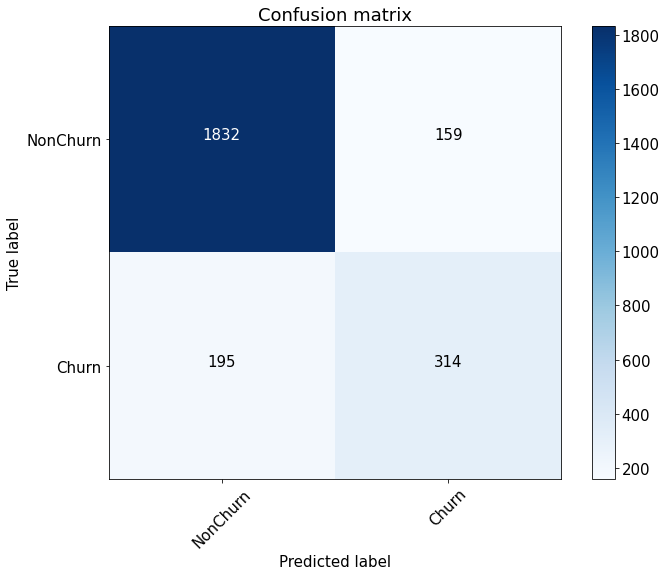

In [206]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Можно заметить, что мы очень сильно ошибаемся в сторону False Negatives, т.е у нас много тех, кто ушел в отток на самом деле, но при выбранном нами пороге в 0.38 мы не считаем их таковыми. 

### Пример с перебором параметров с помощью GridSearch

Сетка с параметрами

In [207]:
from sklearn.model_selection import GridSearchCV

params={'classifier__max_features':[0.3, 0.5, 0.7],
        'classifier__min_samples_leaf':[1, 2, 3],
        'classifier__max_depth':[None]
        }

Запускаем перебор

In [208]:
grid = GridSearchCV(pipeline,
                    param_grid=params,
                    cv=6,
                    refit=False)

# search = grid.fit(X_train, y_train)
# search.best_params_

Обучаем модель уже сновыми параметрами

In [209]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(max_depth=None, max_features=0.5, 
                                          min_samples_leaf=3, random_state=42)),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

Best Threshold=0.389431, F-Score=0.653, Precision=0.661, Recall=0.646
Confusion matrix, without normalization
[[1822  169]
 [ 181  328]]


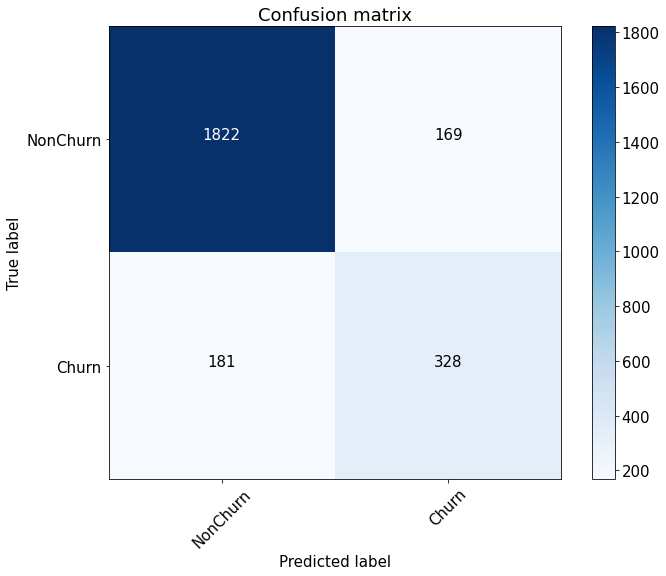

In [210]:
preds = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

## Логистическая регрессия

In [211]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)), 
                ('scaler', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

In [212]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Best Threshold=0.289522, F-Score=0.510, Precision=0.462, Recall=0.568
Confusion matrix, without normalization
[[1655  336]
 [ 221  288]]


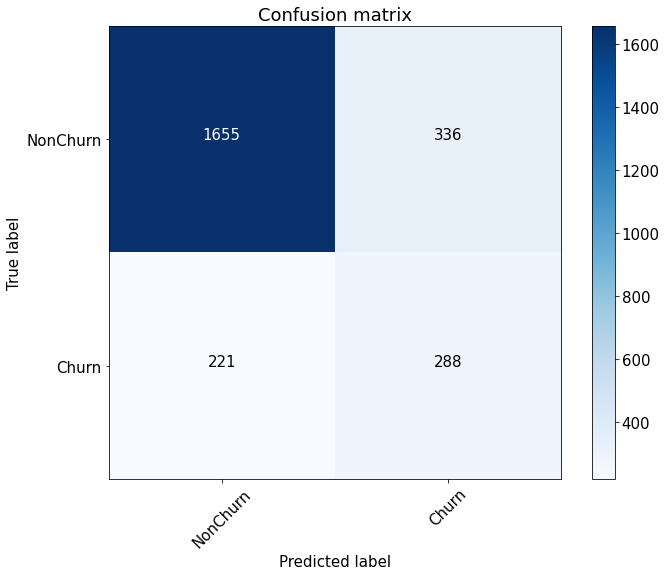

In [213]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

#обучим наш пайплайн
pipeline.fit(X_train, y_train)

#наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]


precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))


#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

## Подбор параметров

In [214]:
params={'classifier__penalty':['l1', 'l2', 'elasticnet', None],
        'classifier__tol':[0.0001, 0.00001, 0.000001],
        'classifier__C':[0.1, 0.5, 1],
        'classifier__class_weight':[{0:0.3, 1:0.7}, {0:0.5, 1:0.5}, {0:0.2, 1:0.8}],
        'classifier__random_state':[42],
        'classifier__solver':['lbfgs','liblinear'],
        'classifier__max_iter':[100,200,500],
        'classifier__verbose':[0, 1],
        'classifier__l1_ratio':[None, 0.5, 1]        
        }

In [215]:
grid = GridSearchCV(pipeline,
                    param_grid=params,
                    cv=4,
                    refit=False)

# search = grid.fit(X_train, y_train)
# search.best_params_

In [216]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(C=0.1, class_weight = {0: 0.5, 1: 0.5},l1_ratio=None,max_iter=100,penalty='l1', random_state=42, solver='liblinear', tol=0.0001, verbose=0))
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

Best Threshold=0.245705, F-Score=0.511, Precision=0.416, Recall=0.662
Confusion matrix, without normalization
[[1518  473]
 [ 173  336]]


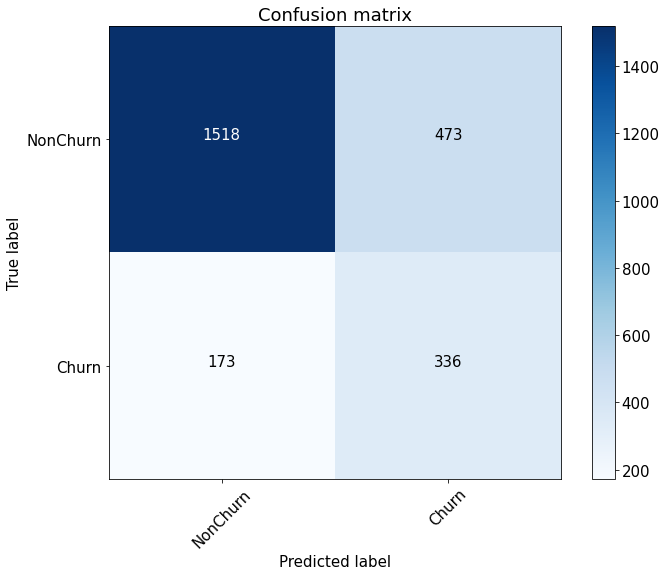

In [217]:
preds = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Вывод: до подбора парааметров F-Score=0.510, Precision=0.462, Recall=0.568, после подбора параметров F-Score=0.511, Precision=0.416, Recall=0.662. F-мера увеличилась совсем незначительно, точность снизилась, но увеличилась полнота. С точки зрения DS метрик для данной задачи показатели улучшились, так как после подбора гиперпараметров модель находит большую часть потенциальных претендентов на отток правильно, но в то же время точность работы модели снизилась, что ведет к осуществлению ненужных затрат. Необходимо провести дополнительный анализ с точки зрения финансовых затрат на удержание клиента.
В целом логистическая регрессия справляется с задачей контрактного оттока хуже, чем случайный лес.

## XGBClassifier

In [218]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
            ])
    final_transformers.append((cont_col, cont_transformer))

In [219]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Best Threshold=0.373318, F-Score=0.626, Precision=0.619, Recall=0.633
Confusion matrix, without normalization
[[1793  198]
 [ 188  321]]


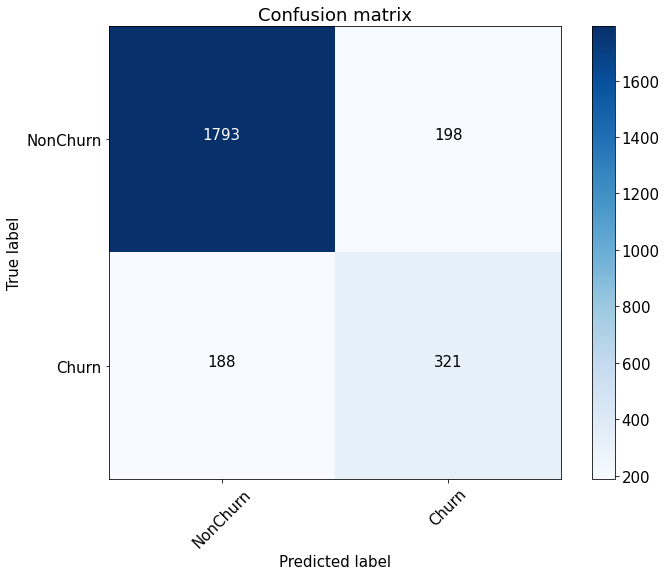

In [220]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', XGBClassifier(random_state = 42)),
])

#обучим наш пайплайн
pipeline.fit(X_train, y_train)

#наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]


precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))


#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

## Подбор параметров

In [221]:
params = {'classifier__n_estimators':[100, 500, 1000, 2000],
          'classifier__max_depth':[4, 5, 6], 'classifier__learning_rate':[0.01, 0.005],  
          'classifier__random_state':[42]}

In [222]:
grid = GridSearchCV(pipeline,
                    param_grid=params,
                    cv=4,
                    refit=False)

# search = grid.fit(X_train, y_train)
# search.best_params_

In [223]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', XGBClassifier(learning_rate=0.01,max_depth=5,n_estimators=2000,random_state=42))
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

Best Threshold=0.358628, F-Score=0.647, Precision=0.637, Recall=0.658
Confusion matrix, without normalization
[[1800  191]
 [ 175  334]]


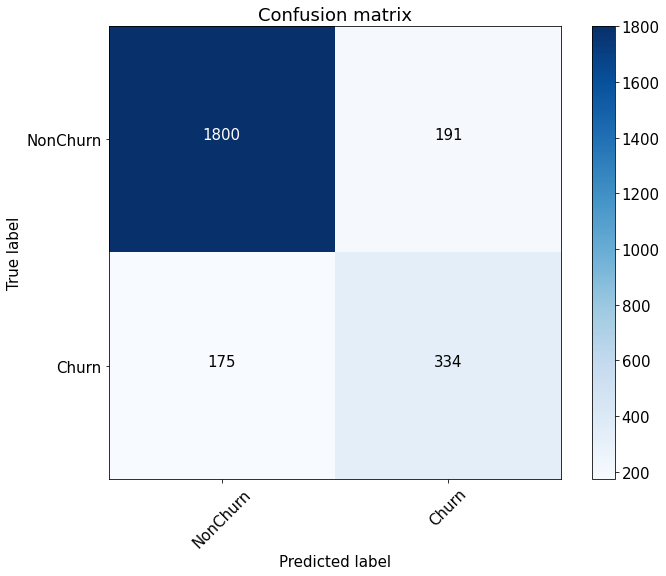

In [224]:
preds = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Вывод: в результате подбора гиперпараметров удалось увеличить F-Score с 0.626 до 0.647, при этом precision вырос c 0.619 до 0,637, Recall вырос с 0.633 до 0.658. 

При этом модель случайного леса дает f-score после подбора параметров 0.653, Precision 0.661, Recall 0.646, это выше протестированных нами в домашнем задании моделей, но необходимо проводить анализ дополнительно, используя финансовые метрики с учетом данных по расходам на удержание клиента.

В качестве модели для оценки экономической эффективности проанализируем модель xgboost, так как у нее самый высокий recall при относительно стабильном precision и она показывает большую эффективность по сравнению с логистической регрессией.

## Выбор оптимального порога вероятности с учетом изменения экономических показателей

In [233]:
fin_result_list = []
Threshold_list = []
for el in range(1,100):
    cnf_matrix = confusion_matrix(y_test, preds>el*0.01)

    TP = cnf_matrix[1,1]
    TN = cnf_matrix[0,0]
    FP = cnf_matrix[0,1]
    FN = cnf_matrix[1,0]
    
    result = TP*2 - (TP+FP)
    
    fin_result_list.append(result)
    Threshold_list.append(el*0.01)

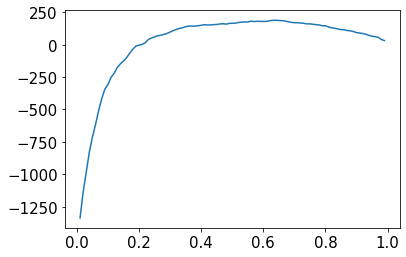

In [234]:
#график изменения показателя экономической эффективности при различных порогах вероятности
plt.plot(Threshold_list, fin_result_list)

In [235]:
best_incom = max(fin_result_list)

In [236]:
max_index = fin_result_list.index(best_incom)

In [237]:
best_threshold_financial = Threshold_list[max_index]

In [238]:
print(f'Самая  высокая финансовая эффективность удержания клиентов достигается при обученной модели XGBClassifier после подбора гиперпараметров при пороге вероятности {best_threshold_financial}, при этом доход составит {best_incom}')

Самая  высокая финансовая эффективность удержания клиентов достигается при обученной модели XGBClassifier после подбора гиперпараметров при пороге вероятности 0.64, при этом доход составит 188
